<a href="https://colab.research.google.com/github/code-vaibhav/ACA-Wikipedia-Simplifier/blob/main/Assignment_4/Team_1_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wikipedia Simplifier Assignment 4 (Sentiment classification using tesorflow)



---


**Team 1:<br>**
Vaibhav goyal<br>
Alisha<br>
kajal deep


---



Mentors:<br>
Ananya Gupta<br>
Rishabh dugaye


---



In [1]:
# importing neccesary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds


In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)  # getting the dataset preprocessed using tfds
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCBJG8M/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCBJG8M/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCBJG8M/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [3]:
for example, label in train_dataset.take(1):  # printing an example entry of dataset
  print('Text: ', example.numpy())
  print('Label: ', label.numpy())

# shuffling the train dataset

BUFFER_SIZE = 10000 
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):   # dataset after shuffling and coverted into batches
  print('Text: ', example.numpy()[0:3])
  print()
  print('Label: ', label.numpy()[0:3])

Text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label:  0
Text:  [b'I am not going to spoil the contents to anyone, who has not yet watched this humble masterpiece by Kay Pollak.<br /><br />A world famous conductor brilliantly played by Michael Nyqvist seeks peace from stress by moving back to his childhood village. The villag

In [4]:
# making encoder to tokenize the data and add padding

VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label:text))
vocab = np.array(encoder.get_vocabulary())
print(vocab[0:20])

encoded_example = encoder(example)[0:3].numpy()  #printing a sample encoding example
print(encoded_example)

['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but']
[[ 10 237  22 ...   0   0   0]
 [  9 181  12 ...   0   0   0]
 [ 51  10  86 ...   0   0   0]]


In [5]:
# tokenization removes punctuation and some words that are not as frequent.
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I am not going to spoil the contents to anyone, who has not yet watched this humble masterpiece by Kay Pollak.<br /><br />A world famous conductor brilliantly played by Michael Nyqvist seeks peace from stress by moving back to his childhood village. The villagers, who has followed the genius in silence, are slowly tempting him to share of his greatness.<br /><br />Each role in this movie, has a very specific purpose and shows a remarkable potential in each of the actors playing their own chord in short but precise words, a symphony of love.<br /><br />Not love in the sense of relationship, but in the tone of the spirit deeply buried within each of the characters, each revealing their own present story, their needs, their skeletons, desires and much more.<br /><br />I shall not forget to mention, the two main parts played by Frida Hallgren and Michael Nyqvist, whose dramas are played in unforgettable harmonies of emotional feedback. They touch each other with a pain connect

#Building the model


In [6]:
# defining the RNN model using Sequential()

model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(
      input_dim=len(encoder.get_vocabulary()),
      output_dim=64,
      mask_zero=True 
  ),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1)
])

# passing an sample for checking the masking effect .
sample_text = ('This movie was cool. I really liked that movie. The animations and graphics are out of the world i definitely recommend that movie')

predictions = model.predict(np.array([sample_text]))
print(predictions)

padding = 'the'*2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions)

[[-0.00897167]]
[[-0.00897167]
 [ 0.00113963]]


In [7]:
# comling model by defining loss function and optimier function

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


#87.2% accuracy on train data

In [8]:
# training the model on training_dataset

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 38s 82ms/step - loss: 0.6820 - accuracy: 0.5135 - val_loss: 0.4819 - val_accuracy: 0.7474
Epoch 2/10
391/391 [==============================] - 30s 77ms/step - loss: 0.4431 - accuracy: 0.7900 - val_loss: 0.4110 - val_accuracy: 0.8005
Epoch 3/10
391/391 [==============================] - 30s 76ms/step - loss: 0.3653 - accuracy: 0.8471 - val_loss: 0.3587 - val_accuracy: 0.8266
Epoch 4/10
391/391 [==============================] - 30s 77ms/step - loss: 0.3419 - accuracy: 0.8529 - val_loss: 0.3382 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 31s 77ms/step - loss: 0.3257 - accuracy: 0.8624 - val_loss: 0.3308 - val_accuracy: 0.8453
Epoch 6/10
391/391 [==============================] - 30s 77ms/step - loss: 0.3057 - accuracy: 0.8680 - val_loss: 0.3256 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 30s 77ms/step - loss: 0.3014 - accuracy: 0.8719 - val_loss: 0.3215 - val_accuracy:

#86.4% accuracy on test data

In [9]:
# checking loss on test_dataset

test_loss, test_acc = model.evaluate(test_dataset)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

391/391 [==============================] - 15s 38ms/step - loss: 0.3193 - accuracy: 0.8642
Test loss:  0.3192571699619293
Test accuracy:  0.8641600012779236


(0.0, 0.6578917190432548)

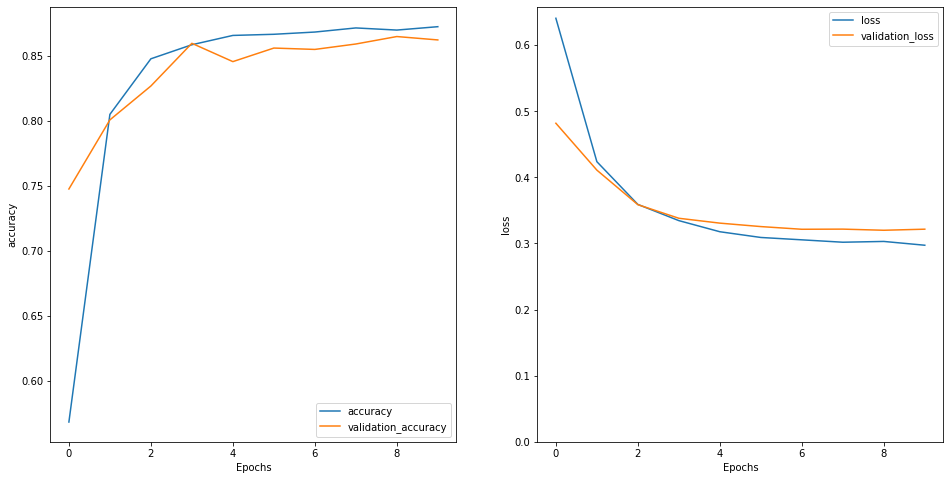

In [17]:
# plotting the graphs 

def plot_graph(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'validation_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graph(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graph(history, 'loss')
plt.ylim(0, None)

In [20]:
# making predictions on real sentences

sample_text = ("The movie was a waste of time. But some things are fine")
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.9860197]]
